# 3D ResNet50 (30 animal classes)

In [1]:
#%%python3 -m pip install --upgrade pip

In [1]:
%pip install mediapipe=='0.10.9'
%pip install opencv-python=='4.8.0.76'

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from utils import VideoDataset, validate_model, train_model, display_frames
from models_resnet import resnet50

2024-02-11 07:34:12.057980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 07:34:15.840048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import json

In [5]:
def save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic):
    with open(f'{save_path}/{model_name}_loss_acc_dynamic.json', 'w') as f:
        json.dump(
            {
                'train_loss_dynamic': train_loss_dynamic,
                'val_accuracy_dynamic': val_accuracy_dynamic
            },
            f)

In [6]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 112

limit_list = [] #["динозавр", "пингвин", "кролик"]

min_frame_count = 25

save = True

annotations_file = "/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DATAFRAME.tsv" # "/content/drive/MyDrive/slovo/SLOVO_DF_SHORT.tsv" #
dataloader_dir =  "/home/jupyter/mnt/s3/rsl-videos/slovo/" #"/content/drive/MyDrive/slovo/dataloaders/"

train_dataloader_name = 'color_frames_train_dataloader.pth'
val_dataloader_name = 'color_frames_val_dataloader.pth'

save_path = "/home/jupyter/mnt/s3/rsl-videos/slovo/models/all/resnet50" #'/content/drive/MyDrive/slovo/models/ResNet50' #'/content/model'

In [7]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
video_labels.tail(5)

,attachment_id,text,user_id,height,width,length,begin,end,group_rank,dataset
19995,81cab3c3-80be-4eb1-b3bf-fd1b69034a16,отложенный,4d26ad833542291c50de9ce88fb4f64a,640,360,131.0,12,73,20,test
19996,4eeeea02-df4c-4667-872e-8387ed31c32e,башенные часы,3018b64d2c938f5b6a0826dfdf486f2c,640,360,145.0,17,83,20,test
19997,d947ab2e-0b6e-4ea7-a5dd-b401c572d177,дважды,3018b64d2c938f5b6a0826dfdf486f2c,640,360,127.0,13,63,20,test
19998,03edb6f1-1c91-46ce-8394-b74bca3b3cd7,время от 0 ночи до 12 дня,472fb939766ece63eb06e2d0e10eb679,840,358,178.0,16,138,19,test
19999,5393ec0c-85a4-4980-a2da-e84259050d83,время от 0 ночи до 12 дня,30eae85220a3d47b79b9955a08d31d63,640,360,205.0,32,172,20,test


In [8]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 1000. Example classes: ('Ё', 'А', 'Р', 'Е', 'Ч')


In [9]:
train_dataloader = torch.load(dataloader_dir + train_dataloader_name)
print(f"Train dataloader contains: {len(train_dataloader)} videos")
val_dataloader = torch.load(dataloader_dir + val_dataloader_name)
print(f"Val dataloader contains: {len(val_dataloader)} videos")

Train dataloader contains: 16000 videos
Val dataloader contains: 2000 videos


In [10]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  for dl in [train_dataloader, val_dataloader]:
    dl.num_workers = 0
    dl.pin_memory = True
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


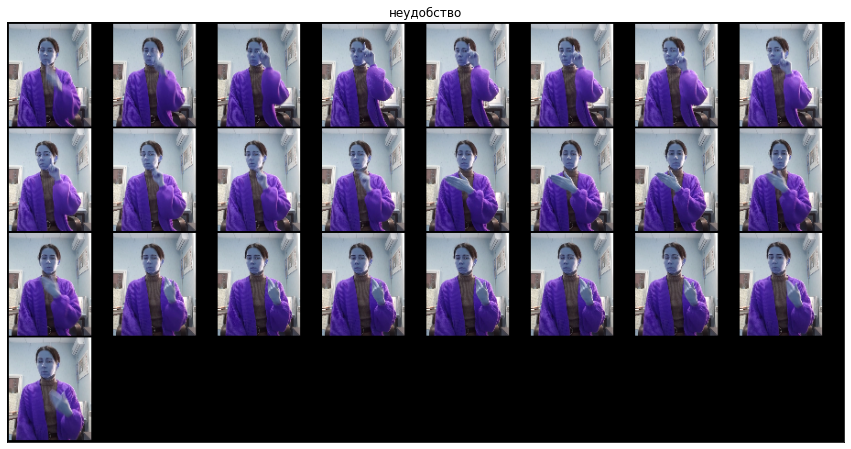

In [11]:
display_frames(n_frames=1, dataloader=train_dataloader, classes=classes)

In [12]:
frames, labels = next(iter(val_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 112, 112])
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([889])


# ResNet 50, $lr = 10^{-3}$

In [16]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [17]:
#print(resnet)
# Print trainable parameters
# for name, param in resnet.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

In [18]:
frames, labels = next(iter(val_dataloader))
frames = frames.to(device)
resnet.to(device)
print(f"Output shape: {resnet(frames/255).shape}") # batch size, number of classes

Output shape: torch.Size([1, 1000])


In [19]:
lr = 10**(-3)
model_name = "ResNet50_all_lr10-3"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=7.3213; val acc=0.000
Train Epoch 2/30: train_loss=7.2847; val acc=0.001
Train Epoch 3/30: train_loss=7.1644; val acc=0.001
Train Epoch 4/30: train_loss=7.1344; val acc=0.001
Train Epoch 5/30: train_loss=7.1203; val acc=0.001
Train Epoch 6/30: train_loss=7.1098; val acc=0.001
Train Epoch 7/30: train_loss=7.1088; val acc=0.001
Train Epoch 8/30: train_loss=7.1162; val acc=0.001
Train Epoch 9/30: train_loss=7.1144; val acc=0.001
Train Epoch 10/30: train_loss=7.1184; val acc=0.001
Train Epoch 11/30: train_loss=7.1116; val acc=0.002
Train Epoch 12/30: train_loss=7.0998; train_loss=7.0751; val acc=0.001
Train Epoch 15/30: train_loss=7.0686; val acc=0.002
Train Epoch 16/30: train_loss=7.0507; val acc=0.001
Train Epoch 17/30: train_loss=7.0395; val acc=0.002
Train Epoch 18/30: train_loss=7.0253; val acc=0.001
Train Epoch 19/30: train_loss=7.0021; val acc=0.001
Train Epoch 20/30: train_loss=6.9607; val acc=0.001
Train Epoch 21/30: train_loss=6.9259; val acc=0.001
Tr

# ResNet 50, $lr = 10^{-4}$

In [ ]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
lr = 10**(-4)
model_name = "ResNet50_all_lr10-4"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=7.4498; val acc=0.001
Train Epoch 2/30: train_loss=6.9478; val acc=0.001
Train Epoch 3/30: train_loss=6.9352; val acc=0.001
Train Epoch 4/30: train_loss=6.9322; val acc=0.001
Train Epoch 5/30: train_loss=6.9183; val acc=0.002
Train Epoch 6/30: train_loss=6.9086; val acc=0.001
Train Epoch 7/30: train_loss=6.8966; val acc=0.001
Train Epoch 8/30: train_loss=6.8717; val acc=0.001
Train Epoch 9/30: train_loss=6.8172; val acc=0.001
Train Epoch 10/30: train_loss=6.6798; val acc=0.003
Train Epoch 11/30: train_loss=6.3904; val acc=0.006
Train Epoch 12/30: train_loss=5.9384; val acc=0.006
Train Epoch 13/30: train_loss=5.378; val acc=0.016
Train Epoch 14/30: train_loss=4.7433; val acc=0.028
Train Epoch 15/30: train_loss=4.0889; val acc=0.024
Train Epoch 16/30: train_loss=3.4334; val acc=0.029
Train Epoch 17/30: train_loss=2.7942; val acc=0.037
Train Epoch 18/30: train_loss=2.1644; val acc=0.037
Train Epoch 19/30: train_loss=1.657; val acc=0.034
Train Epoch 20/30: trai

# ResNet 50, $lr = 10^{-5}$

In [13]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [14]:
lr = 10**(-5)
model_name = "ResNet50_all_lr10-5"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr)

In [15]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=7.3366; val acc=0.001
Train Epoch 2/30: train_loss=6.955; val acc=0.001
Train Epoch 3/30: train_loss=6.9276; val acc=0.001
Train Epoch 4/30: train_loss=6.8764; val acc=0.001
Train Epoch 5/30: train_loss=6.7465; val acc=0.003
Train Epoch 6/30: train_loss=6.4522; val acc=0.004
Train Epoch 7/30: train_loss=5.8911; val acc=0.012
Train Epoch 8/30: train_loss=4.9488; val acc=0.021
Train Epoch 9/30: train_loss=3.9746; val acc=0.033
Train Epoch 10/30: train_loss=2.9997; val acc=0.037
Train Epoch 11/30: train_loss=2.0367; val acc=0.026
Train Epoch 12/30: train_loss=1.2752; val acc=0.031
Train Epoch 13/30: train_loss=0.8219; val acc=0.035
Train Epoch 14/30: train_loss=0.5798; val acc=0.033
Train Epoch 15/30: train_loss=0.4567; val acc=0.029
Train Epoch 16/30: train_loss=0.3733; val acc=0.033
Train Epoch 17/30: train_loss=0.3198; val acc=0.039
Train Epoch 18/30: train_loss=0.2716; val acc=0.038
Train Epoch 19/30: train_loss=0.2437; val acc=0.033
Train Epoch 20/30: tra

# ResNet 50, $lr = 10^{-6}$

In [16]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [17]:
lr = 10**(-6)
model_name = "ResNet50_all_lr10-6"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr)

In [18]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: train_loss=7.2628; val acc=0.002
Train Epoch 2/30: train_loss=7.0237; val acc=0.001
Train Epoch 3/30: train_loss=6.8257; val acc=0.001
Train Epoch 4/30: train_loss=6.612; val acc=0.001
Train Epoch 5/30: train_loss=6.3301; val acc=0.002
Train Epoch 6/30: train_loss=5.9359; val acc=0.003
Train Epoch 7/30: train_loss=5.4376; val acc=0.002
Train Epoch 8/30: train_loss=4.8525; val acc=0.003
Train Epoch 9/30: train_loss=4.1795; val acc=0.002
Train Epoch 10/30: train_loss=3.4378; val acc=0.004
Train Epoch 11/30: train_loss=2.6536; val acc=0.004
Train Epoch 12/30: train_loss=1.8975; val acc=0.005
Train Epoch 13/30: train_loss=1.2367; val acc=0.004
Train Epoch 14/30: train_loss=0.7342; val acc=0.007
Train Epoch 15/30: train_loss=0.436; val acc=0.003
Train Epoch 16/30: train_loss=0.2933; val acc=0.003
Train Epoch 17/30: train_loss=0.21; val acc=0.004
Train Epoch 18/30: train_loss=0.1688; val acc=0.005
Train Epoch 19/30: train_loss=0.136; val acc=0.005
Train Epoch 20/30: train_l

# ResNet 50, $lr = StepLR$

In [22]:
resnet = resnet50()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class)
resnet.to(device)
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [24]:
lr = (10**(-4)) * 5
model_name = "ResNet50_all_step_lr"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 30

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}, lr={scheduler.get_last_lr()[0]:.10f} : {optimizer.param_groups[-1]['lr']:.10f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/30: 